### Import libraries

In [1]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
import tensorflow.keras.backend as K
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
import os
from data_generation import *
from batch_creator import *
from gp_kernels import *
from gp_priors import *
from gp_plots import *

Using TensorFlow backend.


In [ ]:
plot_gp_prior(4, n=20)

In [2]:
def create_batch_gp_mim_2(pos, tar, pos_mask, batch_s=128):
    '''
    Get a batch of positions, targets and position mask from data generated 
    by data_generator_for_gp_mimick_gpt function and from position_mask function 
    -------------------------
    Parameters:
    pos (2D np array): 1st/2nd output from data_generator_for_gp_mimick_gpt function 
    tar (2D np array): 3rd/4th output from data_generator_for_gp_mimick_gpt function  
    pos_mask (4D np.array): output from position_mask function 
    batch_s (int): deafult 128
    -------------------------
    Returns:
    batch_pos_tr (2D np array)
    batch_tar_tr (2D np array)
    batch_pos_mask (4D np array)
    batch_idx_tr (1D np array): indices (=row numbers) chosen for current batch
    
    '''
    shape = tar.shape[0]
    batch_idx_tr = np.random.choice(list(range(shape)), batch_s)
    batch_tar_tr = tar[batch_idx_tr, :]
    batch_pos_tr = pos[batch_idx_tr, :]
    batch_pos_mask = pos_mask[batch_idx_tr, :, :, :]
    return batch_pos_tr, batch_tar_tr , batch_pos_mask, batch_idx_tr

In [3]:
def data_generator_for_gp_mimick_gpt(num_obs, kernel, tr_percent=0.8):
    '''
    Generator for training a GPT inspired netowrk. Make sure x is drawn in a range that 
    Doesn't include 0 --> 0 is currently used for padding.
    -----------------------
    Parameters:
    num_obs (int): how many observations to generate
    kernel (function of am SKlearn kernel object): e.g. rbf_kernel which comes from gp_kernels file
    tr_percent (float): daefult 0.8
    -----------------------
    Returns:
    pad_pos_tr (np array): the first rows * tr_percent from the x generated values padded by zeros according to obs_per_sample  
    pad_pos_te (np array): all rows of x not chosen for training 
    pad_y_fren_tr (np array): the first rows * tr_percent from the f_prior generated values padded by zeros according to obs_per_sample  
    pad_y_fren_te (np array): all rows of f_prior not chosen for training
    df_tr (np array): positions and targets combined (training) 
    df_te (np array): positions and targets combined (testing) 
    '''
    df = np.zeros((num_obs * 2, 59))
    for i in range(0, num_obs * 2, 2):
        x = np.random.uniform(5, 15, size=(1, 59))
        k = kernel(x)
        f_prior = generate_priors(k, 59, 1)

        df[i, :x.shape[1]] = x
        df[i + 1, :x.shape[1]] = f_prior

    rows = df.shape[0]
    cols = df.shape[1]
    tr_rows = int(tr_percent * rows)
    tr_rows = tr_rows if tr_rows % 2 == 0 else tr_rows + 1
    df_tr = df[:tr_rows, :]
    df_te = df[tr_rows:, :]
    
    # get all even rows
    pad_pos_tr = df_tr[::2, :]
    pad_pos_te = df_te[::2, :]
    # get all odd rows
    pad_y_fren_tr = df_tr[1::2, :]
    pad_y_fren_te = df_te[1::2, :]

    return pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, df_tr, df_te

In [4]:
def position_mask(arr):
    '''
    This tries to emulate the kernel matrix. 
    In the first stage we have a 2X2 matrix of zeros, next
    3X3 matrix of zeros, etc.
    -------------------------
    Parameters:
    arr (np array): the 1st/2nd output from data_generator_for_gp_mimick_gpt function
    -------------------------
    Returns:
    mask (4D np array): if there are 100 rows and 50 cols in arr then this will 
    return [100, 49, 50, 50] array -- where the first dim is observation number 
    second dim is timestamp and third+fourth dim are the mask matrix.
    '''
    rows = arr.shape[0]
    cols = arr.shape[1]
    mask = np.ones((rows, cols - 1, cols, cols))
    specific = np.sum(np.equal(arr, 0), 1)
    for i in range(2, cols + 1):
        mask[:, i - 2, :i, :i] = np.zeros((i, i))
    for j in range(rows):
        k  = specific[j]
        mask[j, k:, :, :] = 1
            
    return mask

In [5]:
def create_padding_mask(seq):
    '''
    Used to pad sequences that have zeros where there was no event.
    Typically this will be combined with create_look_ahead_mask function.
    This function is used inside an open session of tensorflow. 
    To try it out create a tf.constant tensor.
    -------------------
    Parameters:
    seq (tensor): shape is (batch_size, seq_len)
    
    -------------------
    Returns:
    A binary tensor  (batch_size, 1, seq_len): 1 where there was no event and 0 otherwise.
    
    '''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention. Extra dimension is used in create_masks function
    return seq[:, tf.newaxis, :]  

In [6]:
def create_tar_mask(size):
    '''
    '''
    mask = tf.linalg.diag(tf.ones(size, size))
    return mask

In [7]:
create_tar_mask(3)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int32)>

In [8]:
def create_look_ahead_mask(size):
    '''
    Hide future outputs from a decoder style network.
    Used typically together with create_padding_mask function
    -----------------------
    Parameters:
    size (int): max sequnce length 
    
    -----------------------
    Returns:
    mask (tensor): shape is (seq_len X seq_len). Example: if size is 4, returns
    0 1 1 1
    0 0 1 1
    0 0 0 1
    0 0 0 0 
    where 1 signifies what to hide.
    '''
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [9]:
def create_masks(tar):
    '''
    Create unified masking hiding future from current timestamps and hiding paddings. 
    -------------------
    Parameters: 
    tar (tensor): batch of padded target sequences 
    -------------------
    Returns: 
    combined_mask_tar  (tensor): shape is batch_size X max_seq_len X max_seq_len
    '''
    
    tar_padding_mask = create_padding_mask(tar)
    ## this will be batch_size X 1 X 40

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # if max seq length is 40 -- > this will be 40X40 
    
    
    ## This will also be (64, 40, 40)
    combined_mask_tar = tf.maximum(tar_padding_mask, look_ahead_mask)
    
    
    return combined_mask_tar

In [10]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generator_for_gp_mimick_gpt(50000, rbf_kernel)

In [11]:
pp = position_mask(pad_pos_tr)

In [12]:
pp_te = position_mask(pad_pos_te)

In [13]:
loss_object = tf.keras.losses.MeanSquaredError()

In [14]:
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [15]:
def loss_function(real, pred):
    '''
    Masked MSE. Since the target sequences are padded, 
    it is important to apply a padding mask when calculating the loss.
    ----------------
    Parameters:
    real (tf.tensor float64): shape batch_size X max_seq_len. True values of sequences.
    pred (tf.tensor float64): shape batch_size X max_seq_len. Predictions from GPT network. 
    
    ----------------
    Returns: 
    loss value (tf.float64)
    '''
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
#     print('loss_ :', loss_)
#     shape= (128X58)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [16]:
def dot_prod_position(q, k, v, mask):
    '''
    Used to create a pseudo XX^T covariance matrix for each 
    positional sequence in the batch.
    ------------------
    Parameters: 
    q : shape (batch_size X max_seq_len X l). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    k : shape (batch_size X max_seq_len X l). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    v : shape (batch_size X max_seq_len X l). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    mask: shape (batch_size X (max_seq_len - 1) X max_seq_len X max_seq_len). The positional mask created by position_mask function and selected in batch indices 
    
    ------------------
    Returns:
    u2 (tf.tensor float64): shape (batch_size X (max_seq_len - 1) X l X l).
    Each observation (1st dim) has seq_len - 1 timestamps (2nd dim) and each timestamp has an associated
    l X l pseudo covariance matrix (3rd & 4th dims).
    
    '''
    qk = tf.matmul(q, k, transpose_b = True)
    qk = tf.cast(qk[:, tf.newaxis, :, :], tf.float64)
#     print('qk1: ', qk)
#     shape=(128, 1, 59, 59)

#     print('pos_mask: ', mask)
#     shape=(128, 58, 59, 59)
    if mask is not None:
        qk +=  ((tf.cast(mask, tf.float64)) * -1e9)
        
#     print('qk2: ', qk)
# shape=(128, 58, 59, 59)

    qk = tf.reshape(qk, shape = [tf.shape(mask)[0], tf.shape(mask)[1], -1])
    
#     print('qk3: ', qk)
#     shape=(128, 58, 3481)
    
    qk = tf.reshape(tf.nn.softmax(qk, axis = -1), shape = [tf.shape(mask)[0], tf.shape(mask)[1], tf.shape(mask)[2], tf.shape(mask)[3]])
    
#     print('qk4: ', qk)
    #shape=(128, 58, 59, 59)
    
    v = tf.cast(v[:, tf.newaxis, :, :], tf.float64)
    
    u = tf.transpose(tf.matmul(qk, v), perm = [0, 1, 3 ,2])
    
#     print('u: ', u)
#     shape=(128, 58, 16, 59)
    
    u2 = tf.matmul(u, v)
    
    
    return u2

In [17]:
def dot_product_attention(q, k, v, mask):
    '''
    Attention inspired by Transformer (but not the same). The Transformer embeds the 
    target words to q (query), k (key), v (value). So if we have a batch of 128 sequences 
    with max length 40 and embedding layer is 20, we will get shape q = shape k = shape v
    = (128 X  max sequence length X 20). The Transformer then transposes k 
    to get after matmul (128 X max seq X max seq) matrix. We then apply relu layer (unlike in Transformer)
    ---------------------
    Parameters:
    q (tf.tensor float64): shape (batch_size, max_seq_len - 1, l)
    k (tf.tensor float64): shape (batch_size, max_seq_len - 1, l)
    v (tf.tensor float64): shape (batch_size, max_seq_len - 1, l)
    mask (tf.tensor float64): shape (batch_size, max_seq_len - 1, max_seq_len - 1)
    ---------------------
    Returns:
    out_tar: shape (batch_size, max_seq_len - 1, l). The sequences after embedding (or Dense layer) weighted by attention_weights. 
    attention_weights : shape (batch_size, max_seq_len - 1, max_seq_len - 1). Weights to assign for each sequence member at each timestamp (2nd dim).
    matmul_qk: shape (batch_size, max_seq_len - 1, max_seq_len - 1)
    
    
    '''
    # similarity
    # q = k = v  shape := (batch_size, max_seq_len - 1, l)
    matmul_qk = tf.matmul(q, k, transpose_b = True, name = 'qk')
#     print('matmul_qk: ', matmul_qk)
#     shape=(128, 58, 58)
    
    nl_qk = tf.cast(tf.nn.relu(matmul_qk, name = 'nl_qk'), tf.float64) 
#     print('nl_qk: ', nl_qk)
#     shape=(128, 58, 58)
#     nl_qk shape := (batch_size, max_seq_len - 1, max_seq_len - 1)

    # -1e9 will turn the softmax output in this locations to zero
    # this is a good mask as an input for softmax -- we need also masking when 
    # want to use matmul as is 
    
    if mask is not None:
        nl_qk +=  ((tf.cast(mask, tf.float64)) * -1e9)
    
        
#     print('nl_qk after mask: ', nl_qk)
#     shape=(128, 58, 58)
        
     # turn simialrity to scores
    attention_weights = tf.nn.softmax(nl_qk, axis = -1, name = 'attention_weights')
    # Notice that for all the rows where 
    # everything is 0, the masking will turn everything to -inf
    # and the output from the softmax would be 1/num_cols 
    # (try a = tf.constant([-1e9, -1e9, -1e9]), tf.nn.softmax(a))
    # So we can expect an output from these rows which we want to ignore
    # this will be enforced in the masking of the loss function 
    
#     print('attention_weights: ', attention_weights)
#     shape=(128, 58, 58)
   
    # weight values 
    # attention_weights shape := (batch_size, max_seq_len - 1, max_seq_len - 1), 
    # v shape := batch_size X (max_seq_len - 1) X l
    out_tar = tf.matmul(attention_weights, tf.cast(v, tf.float64))
    
#   print('out_tar: ', out_tar)
#   shape=(128, 58, l)
    
    return out_tar, attention_weights, matmul_qk

In [24]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, l):
        super(Decoder, self).__init__()
        
        self.l = l
        
        self.wq = tf.keras.layers.Dense(l, name = 'wq')
        self.wk = tf.keras.layers.Dense(l, name = 'wk')
        self.wv = tf.keras.layers.Dense(l, name = 'wk')                    
        
        self.hq = tf.keras.layers.Dense(l, name = 'hq')
        self.hk = tf.keras.layers.Dense(l, name = 'hk')
        self.hv = tf.keras.layers.Dense(l, name = 'hv')
        
        self.B = tf.keras.layers.Dense(l, name = 'B')
        self.A = tf.keras.layers.Dense(1, name = 'A')

    #a call method, the layer's forward pass
    def call(self, tar_position, tar_inp, training, pos_mask, tar_mask):
        
        # Adding extra dimension to allow multiplication of 
        # a sequnce with itself. 
        tar_position = tar_position[:, :, tf.newaxis]
        
        q_p = self.wq(tar_position) 
        k_p = self.wk(tar_position)
        v_p = self.wk(tar_position)


#         print('v_p: ', v_p)
        #shape=(128, 59, 16)
        
        pos_attn1 = dot_prod_position(q_p, k_p, v_p, mask = pos_mask)
#         print('pos_attn1 :', pos_attn1)
#       shape=(128, 58, 16, 16)
    
        tar_inp = tar_inp[:, :, tf.newaxis]

        
        q = self.hq(tar_inp) 
        k = self.hk(tar_inp)
        v = self.hv(tar_inp)
        
#         print('q :', q)
#       shape=(128, 58, 16)

        tar_attn1, _, _ = dot_product_attention(q, k, v, tar_mask)
        # tar_attn1 is (batch_size, max_seq_len - 1, tar_d_model)

#         print('tar_attn1 :', tar_attn1)
#       shape=(128, 58, l)
#       shape=(128, 58, 16)
        tar_attn1 = tar_attn1[:, :, :, tf.newaxis]
        
        tar1 = self.B(tar_attn1)
        
#         print('tar1 :', tar1)
        # shape=(128, 58, 16, 16)

        L = tf.matmul(tar1, tf.cast(pos_attn1, tf.float64))
        
#         print('L :', L)
        # shape=(128, 58, 16, 16)
        
        L2 = self.A(tf.reshape(L, shape = [tf.shape(L)[0], tf.shape(L)[1] ,self.l ** 2])) 
        
#         print('L2 :', L2)
      # shape=(128, 58, 1)  
        
        return tf.squeeze(L2)

In [25]:
decoder = Decoder(16)

In [26]:
@tf.function
def train_step(pos, tar, pos_mask):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    combined_mask_tar = create_masks(tar_inp)
    with tf.GradientTape(persistent=True) as tape:
        pred = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)
#         print('pred: ')
#         tf.print(pred)

        loss = loss_function(tar_real, pred)

    gradients = tape.gradient(loss, decoder.trainable_variables)
#     tf.print(gradients)
# Ask the optimizer to apply the processed gradients.
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
#     b = decoder.trainable_weights[0]
#     tf.print(tf.reduce_mean(b))

In [27]:
@tf.function
def test_step(pos_te, tar_te, pos_mask_te):
    '''
    
    ---------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ---------------
    
    '''
    tar_inp_te = tar_te[:, :-1]
    tar_real_te = tar_te[:, 1:]
    combined_mask_tar_te = create_masks(tar_inp_te)
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    pred = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)
    t_loss = loss_function(tar_real_te, pred)
    test_loss(t_loss)

In [28]:
tf.keras.backend.set_floatx('float64')

In [29]:
if __name__ == '__main__':
    EPOCHS = 50
    batch_s  = 128
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    
    for epoch in range(EPOCHS):
        start = time.time()
#       train_loss.reset_states()

        for batch in range(num_batches):
            batch_pos_tr, batch_tar_tr, batch_pos_mask, _ = create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, pp)
            # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
            # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
            train_step(batch_pos_tr, batch_tar_tr, batch_pos_mask)

            if batch % 50 == 0:
                batch_pos_te, batch_tar_te, batch_pos_mask_te, _ = create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te, pp_te)
                test_step(batch_pos_te, batch_tar_te, batch_pos_mask_te)
                
                print ('Epoch {} Batch {} train Loss {:.4f} test Loss {:.4f}'.format(
                  epoch + 1, batch, train_loss.result(), test_loss.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 train Loss 5.2071 test Loss 2.7027
Epoch 1 Batch 50 train Loss 0.4357 test Loss 1.3576
Epoch 1 Batch 100 train Loss 0.2238 test Loss 0.9080
Epoch 1 Batch 150 train Loss 0.1520 test Loss 0.6826
Epoch 1 Batch 200 train Loss 0.1159 test Loss 0.5472
Epoch 1 Batch 250 train Loss 0.0942 test Loss 0.4572
Epoch 1 Batch 300 train Loss 0.0797 test Loss 0.3930
Time taken for 1 epoch: 401.82344007492065 secs

Epoch 2 Batch 0 train Loss 0.0769 test Loss 0.3446
Epoch 2 Batch 50 train Loss 0.0673 test Loss 0.3074
Epoch 2 Batch 100 train Loss 0.0600 test Loss 0.2780
Epoch 2 Batch 150 train Loss 0.0542 test Loss 0.2533
Epoch 2 Batch 200 train Loss 0.0496 test Loss 0.2330
Epoch 2 Batch 250 train Loss 0.0458 test Loss 0.2155
Epoch 2 Batch 300 train Loss 0.0427 test Loss 0.2005
Time taken for 1 epoch: 400.69294691085815 secs

Epoch 3 Batch 0 train Loss 0.0420 test Loss 0.1877
Epoch 3 Batch 50 train Loss 0.0394 test Loss 0.1764
Epoch 3 Batch 100 train Loss 0.0372 test Loss 0.1663
Epoch 3 Ba

Epoch 20 Batch 200 train Loss 0.0083 test Loss 0.0244
Epoch 20 Batch 250 train Loss 0.0083 test Loss 0.0242
Epoch 20 Batch 300 train Loss 0.0082 test Loss 0.0241
Time taken for 1 epoch: 401.88769698143005 secs

Epoch 21 Batch 0 train Loss 0.0082 test Loss 0.0239
Epoch 21 Batch 50 train Loss 0.0082 test Loss 0.0238
Epoch 21 Batch 100 train Loss 0.0081 test Loss 0.0236
Epoch 21 Batch 150 train Loss 0.0081 test Loss 0.0235
Epoch 21 Batch 200 train Loss 0.0080 test Loss 0.0234
Epoch 21 Batch 250 train Loss 0.0080 test Loss 0.0232
Epoch 21 Batch 300 train Loss 0.0079 test Loss 0.0231
Time taken for 1 epoch: 401.2964279651642 secs

Epoch 22 Batch 0 train Loss 0.0079 test Loss 0.0229
Epoch 22 Batch 50 train Loss 0.0079 test Loss 0.0228
Epoch 22 Batch 100 train Loss 0.0079 test Loss 0.0227
Epoch 22 Batch 150 train Loss 0.0078 test Loss 0.0225
Epoch 22 Batch 200 train Loss 0.0078 test Loss 0.0224
Epoch 22 Batch 250 train Loss 0.0077 test Loss 0.0223
Epoch 22 Batch 300 train Loss 0.0077 test Los

Time taken for 1 epoch: 398.0005359649658 secs

Epoch 40 Batch 0 train Loss 0.0055 test Loss 0.0136
Epoch 40 Batch 50 train Loss 0.0055 test Loss 0.0136
Epoch 40 Batch 100 train Loss 0.0055 test Loss 0.0136
Epoch 40 Batch 150 train Loss 0.0055 test Loss 0.0135
Epoch 40 Batch 200 train Loss 0.0055 test Loss 0.0135
Epoch 40 Batch 250 train Loss 0.0055 test Loss 0.0134
Epoch 40 Batch 300 train Loss 0.0055 test Loss 0.0134
Time taken for 1 epoch: 396.4347040653229 secs

Epoch 41 Batch 0 train Loss 0.0055 test Loss 0.0134
Epoch 41 Batch 50 train Loss 0.0054 test Loss 0.0133
Epoch 41 Batch 100 train Loss 0.0054 test Loss 0.0133
Epoch 41 Batch 150 train Loss 0.0054 test Loss 0.0133
Epoch 41 Batch 200 train Loss 0.0054 test Loss 0.0132
Epoch 41 Batch 250 train Loss 0.0054 test Loss 0.0132
Epoch 41 Batch 300 train Loss 0.0054 test Loss 0.0131
Time taken for 1 epoch: 397.91670393943787 secs

Epoch 42 Batch 0 train Loss 0.0054 test Loss 0.0131
Epoch 42 Batch 50 train Loss 0.0054 test Loss 0.0131


In [30]:
pos = df_te[560, :].reshape(1, -1)

In [31]:
tar = df_te[561, :39].reshape(1, -1)

In [36]:
df_te[561, :]

array([0.79421483, 0.82273214, 0.78303935, 0.78081123, 0.84008443,
       0.93063795, 0.75938485, 0.78951207, 0.85226032, 0.82714972,
       0.83747097, 0.82860228, 0.81902547, 0.83490666, 0.8305321 ,
       0.83953733, 0.78421542, 0.82523238, 0.81893981, 0.7845124 ,
       0.79444966, 0.82777025, 0.8737039 , 0.84331259, 0.77790632,
       0.72681742, 0.83917158, 0.8450379 , 0.87636089, 0.89078672,
       0.83436773, 0.81889668, 0.82095995, 0.8350107 , 0.75424744,
       0.87638343, 0.8746333 , 0.78314555, 0.77521238, 0.83750439,
       0.88058447, 0.81881745, 0.91279156, 0.78103321, 0.82639293,
       0.7769952 , 0.81967033, 0.82250717, 0.84540936, 0.74881181,
       0.84004019, 0.79126806, 0.81754296, 0.86202801, 0.80911221,
       0.87486705, 0.71336508, 0.8125778 , 0.76446845])

In [32]:
def evaluate(pos, tar, pos_mask):
    '''
    
    '''
    combined_mask_tar = create_masks(tar)
    out = decoder(pos, tar, False, pos_mask, combined_mask_tar)
    return out

In [33]:
def inference(pos, tar, num_steps = 1):
    '''
    
    ------------------
    Parameters:
    pos (2D np array): (n + num_steps) positions 
    tar (2D np array): n targets 
    num_steps (int): how many inference steps are required
    ------------------
    Returns:
    out (tf.tensor float64): the predictions for all timestamps up to n + num_steps  
    
    '''
    n = tar.shape[1]
    temp_pos = pos[:, :(n + 1)]
    pos_mask = position_mask(temp_pos)
    
    out = evaluate(temp_pos, tar, pos_mask)
    print(out[n - 1])
    tar = tf.concat((tar, tf.reshape(out[n - 1], [1, 1])), axis = 1)
    if num_steps > 1:
        out = inference(pos, tar, num_steps - 1)
    
    return out
    

In [34]:
a = inference(pos, tar, 20)

tf.Tensor(0.8241398577782234, shape=(), dtype=float64)
tf.Tensor(0.8241979832058564, shape=(), dtype=float64)
tf.Tensor(0.8242541256248841, shape=(), dtype=float64)
tf.Tensor(0.8243043343657172, shape=(), dtype=float64)
tf.Tensor(0.8243582809798264, shape=(), dtype=float64)
tf.Tensor(0.8243396267129595, shape=(), dtype=float64)
tf.Tensor(0.8243726973824703, shape=(), dtype=float64)
tf.Tensor(0.8234560203767337, shape=(), dtype=float64)
tf.Tensor(0.8234830424281215, shape=(), dtype=float64)
tf.Tensor(0.8235090683135358, shape=(), dtype=float64)
tf.Tensor(0.8235348383079335, shape=(), dtype=float64)
tf.Tensor(0.8237256968841214, shape=(), dtype=float64)
tf.Tensor(0.823977861619993, shape=(), dtype=float64)
tf.Tensor(0.8240096644136029, shape=(), dtype=float64)
tf.Tensor(0.8241489526617438, shape=(), dtype=float64)
tf.Tensor(0.824299003452675, shape=(), dtype=float64)
tf.Tensor(0.8243331891052343, shape=(), dtype=float64)
tf.Tensor(0.8243667639624348, shape=(), dtype=float64)
tf.Tensor(0.

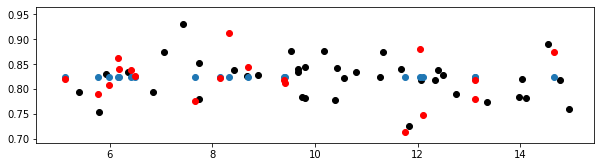

In [37]:
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.scatter(pos[:, :39], tar[:, :39], c='black')
    plt.scatter(pos[:, 39:58], a[39:])
    plt.scatter(pos[:, 39:58], df_te[561, 39:58], c='red')

In [ ]:
# tf.data.Dataset(tf.Tensor(pad_pos_tr, value_index = 0 , dtype = tf.float32))